# Data Analysis

In [1]:
!pip install pingouin

## Imports
Import all the libraries needed.

In [1]:
from __future__ import annotations

from typing import Any, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.stats.multicomp as cmp
import statsmodels.formula.api as sma
import statsmodels.api as sm
import pingouin as pg
import scipy.stats as sts

import pickle
import os

from tqdm import tqdm

SIMULATION_TIME = 68400
STARTING_TIME = 18000.0

P_VALUE = 0.05

pd.set_option('display.max_rows', 20)

## Get files
Get at what time the last run was, then automatically open the last run.

In [2]:
## Get last run
runs = tuple(os.walk("results"))[0][1]
runs.sort()
last_run = runs[-2]
last_run

'1651760000'

In [3]:
# Get last run files
files = tuple(os.walk(f"results/{last_run}"))[0][2]
files

['utilitarian.pickle',
 'base.pickle',
 'top_floor_rest.pickle',
 'ground_floor_rest.pickle',
 'alternative_rest.pickle']

In [4]:
# Open files in DATA
RAW_DATA: dict[str, Any] = {}

for file_name in files:
    with open(f"results/{last_run}/{file_name}", "rb") as f:
        RAW_DATA[file_name.split(".")[0]] = pickle.load(f)

## Convert to analyzable data
All the data is in different numpy matrices, or pandas DataFrames, we combine it into a dataframe s.t. we can get our key indicators.

### Occupancy data

In [5]:
DATA: dict[str, dict[str, Optional[pd.DataFrame]]] = {}

# Ensure we do not waste time reloading parsed data
if os.path.exists(f"results/parsed/{last_run}.pickle"):
    DATA = pickle.load(open(f"results/parsed/{last_run}.pickle", "rb"))

for r_data in RAW_DATA.items():
    strategy_name, d = r_data

    if DATA.get(strategy_name, False):
        continue

    waiting_df: Optional[pd.DataFrame] = None
    elevator_df: Optional[pd.DataFrame] = None
    waiting_df_list_to_add = []
    elevator_df_list_to_add = []
    for iteration, curr_state_history in enumerate(tqdm(d["state_history"])):
        curr_scheduled_events = d["scheduled_events"][iteration]
        waiting_index = pd.MultiIndex.from_product([[0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5]]).set_names(["arrival", "target"])
        columns = pd.MultiIndex.from_product([[iteration], curr_scheduled_events.index]).set_names(["iteration", "time"])
        add_waiting_df = pd.DataFrame({}, index=waiting_index, columns=columns)
        add_elevator_df = pd.DataFrame({}, index=pd.Index([0, 1, 2, 3, 4, 5], name="target"), columns=columns)

        # print(waiting_df)
        for i, values in enumerate(curr_state_history):
            t = curr_scheduled_events.index[i]
            # display(waiting_df.loc[:, (iteration, t)])
            add_waiting_df.loc[:, (iteration, t)] = pd.DataFrame(values["waiting"]).stack()
            add_elevator_df.loc[:, (iteration, t)] = values["elevator"]
        
        if waiting_df is None:
            waiting_df = add_waiting_df
        else:
            waiting_df_list_to_add.append(add_waiting_df)

        if elevator_df is None:
            elevator_df = add_elevator_df
        else:
            elevator_df_list_to_add.append(add_elevator_df)
    
    waiting_df = waiting_df.join(waiting_df_list_to_add) #type:ignore
    elevator_df = elevator_df.join(elevator_df_list_to_add) # type:ignore
    DATA[str(strategy_name)] = {"waiting": waiting_df, "elevator": elevator_df}

    with open(f"results/parsed/{last_run}.pickle", "wb+") as f:
        pickle.dump(DATA, f)

### Event data

In [6]:
event_data_columns = pd.MultiIndex.from_arrays([[], []]).set_names(["strategy", "iteration"])
event_data_index = pd.Index([]).set_names("event_number")
EVENT_DATA: pd.DataFrame = pd.DataFrame({}, columns=event_data_columns, index=event_data_index)

for strategy_name, d in RAW_DATA.items():
    max_length = 0
    max_event_happened = 0
    for iteration, curr_scheduled_events in enumerate(d["scheduled_events"]):
        max_length = max(max_length, curr_scheduled_events.shape[0])
        EVENT_DATA = EVENT_DATA.reindex(range(max_length))
        EVENT_DATA.loc[:, (strategy_name, iteration)] = pd.DataFrame(list(curr_scheduled_events.idxmin(axis=1)))
     
EVENT_DATA

strategy           utilitarian                                      \
iteration                   0                 1                 2    
event_number                                                         
0                   Arrival1,4        Arrival4,0        Arrival5,4   
1             ElevatorArrival4  ElevatorArrival4         DoorClose   
2             ElevatorArrival3         DoorClose  ElevatorArrival4   
3             ElevatorArrival2  ElevatorArrival3         DoorClose   
4             ElevatorArrival1  ElevatorArrival2        Arrival3,0   
...                        ...               ...               ...   
10177                      NaN               NaN               NaN   
10178                      NaN               NaN               NaN   
10179                      NaN               NaN               NaN   
10180                      NaN               NaN               NaN   
10181                      NaN               NaN               NaN   

strategy                                                            \
iteration                   3                 4                 5    
event_number                                                         
0                   Arrival3,0        Arrival4,0        Arrival0,3   
1             ElevatorArrival4  ElevatorArrival4  ElevatorArrival4   
2             ElevatorArrival3         DoorClose  ElevatorArrival3   
3                    DoorClose  ElevatorArrival3  ElevatorArrival2   
4             ElevatorArrival2  ElevatorArrival2  ElevatorArrival1   
...                        ...               ...               ...   
10177                      NaN               NaN               NaN   
10178                      NaN               NaN               NaN   
10179                      NaN               NaN               NaN   
10180                      NaN               NaN               NaN   
10181                      NaN               NaN               NaN   

strategy                                                            \
iteration                   6                 7                 8    
event_number                                                         
0                   Arrival3,0        Arrival5,4        Arrival2,0   
1             ElevatorArrival4         DoorClose  ElevatorArrival4   
2             ElevatorArrival3  ElevatorArrival4  ElevatorArrival3   
3                    DoorClose         DoorClose  ElevatorArrival2   
4             ElevatorArrival2        Arrival2,0         DoorClose   
...                        ...               ...               ...   
10177                      NaN               NaN               NaN   
10178                      NaN               NaN               NaN   
10179                      NaN               NaN               NaN   
10180                      NaN               NaN               NaN   
10181                      NaN               NaN               NaN   

strategy                        ...  alternative_rest                    \
iteration                   9   ...                90                91   
event_number                    ...                                       
0                   Arrival2,0  ...  ElevatorArrival4  ElevatorArrival4   
1             ElevatorArrival4  ...  ElevatorArrival3  ElevatorArrival3   
2             ElevatorArrival3  ...  ElevatorArrival2  ElevatorArrival2   
3             ElevatorArrival2  ...  ElevatorArrival1  ElevatorArrival1   
4                    DoorClose  ...  ElevatorArrival0  ElevatorArrival0   
...                        ...  ...               ...               ...   
10177                      NaN  ...               NaN               NaN   
10178                      NaN  ...               NaN               NaN   
10179                      NaN  ...               NaN               NaN   
10180                      NaN  ...               NaN               NaN   
10181                      NaN  ...               NaN               NaN   

strate

# Key Indicators
We have the following key indicators:
- Average waiting clients (per floor, and in total)
- Average people in the system
- Average travel time (total, and in elevator)
- Average elevator occupancy
- Average elevator movements

## Average elevator movements

**We moeten er nog wel voor zorgen dat de data analyse, de statistische methoden gebruikt die we hebben geleerd.**

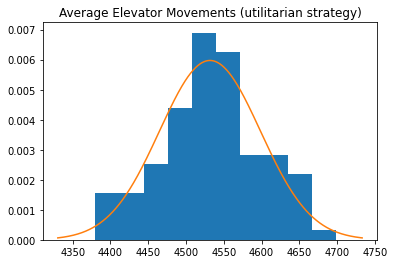

Jaque Bera (p-value, utilitarian strategy): 0.941708670689636


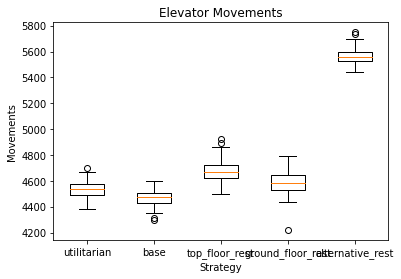

Levene:


,W,pval,equal_var
levene,4.16476,0.002507,False


Welch ANOVA:


,Source,ddof1,ddof2,F,p-unc,np2
0,strategy,4,246.406149,5375.255416,2.323049e-238,0.971167


Pairwise t-test:


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,alternative_rest,base,5564.42,4466.97,1097.45,9.93489,110.464234,8.992806e-15,15.562753
1,alternative_rest,ground_floor_rest,5564.42,4583.13,981.29,9.93489,98.772106,8.992806e-15,13.915507
2,alternative_rest,top_floor_rest,5564.42,4678.71,885.71,9.93489,89.151466,8.992806e-15,12.560104
3,alternative_rest,utilitarian,5564.42,4531.76,1032.66,9.93489,103.942773,8.992806e-15,14.643977
4,base,ground_floor_rest,4466.97,4583.13,-116.16,9.93489,-11.692128,8.992806e-15,-1.647245
5,base,top_floor_rest,4466.97,4678.71,-211.74,9.93489,-21.312768,8.992806e-15,-3.002649
6,base,utilitarian,4466.97,4531.76,-64.79,9.93489,-6.521461,1.720048e-09,-0.918776
7,ground_floor_rest,top_floor_rest,4583.13,4678.71,-95.58,9.93489,-9.620640,8.992806e-15,-1.355404
8,ground_floor_rest,utilitarian,4583.13,4531.76,51.37,9.93489,5.170666,3.363822e-06,0.728469
9,top_floor_rest,utilitarian,4678.71,4531.76,146.95,9.93489,14.791306,8.992806e-15,2.083873


Results


,lower,mean,upper
strategy,,,
utilitarian,4518.601975,4531.76,4544.918025
base,4455.511953,4466.97,4478.428047
top_floor_rest,4662.923396,4678.71,4694.496604
ground_floor_rest,4567.222375,4583.13,4599.037625
alternative_rest,5552.535366,5564.42,5576.304634


In [34]:
elevator_movements = EVENT_DATA.stack().stack().str.contains("Elevator").unstack().unstack().sum().unstack()
plt.hist(elevator_movements.iloc[0], density=True)
plt.title(f"Average Elevator Movements ({elevator_movements.index[0]} strategy)")
_mean, _std = sts.norm.fit(elevator_movements.iloc[0].astype(float))
plt.plot(
    np.arange(
        elevator_movements.iloc[0].mean() - 3*elevator_movements.iloc[0].std(), 
        elevator_movements.iloc[0].mean() + 3*elevator_movements.iloc[0].std(), 
        0.001),
    sts.norm.pdf(np.arange(
        elevator_movements.iloc[0].mean() - 3*elevator_movements.iloc[0].std(), 
        elevator_movements.iloc[0].mean() + 3*elevator_movements.iloc[0].std(),  
        0.001),
        _mean,
        _std
    ))
plt.show()
print(f"Jaque Bera (p-value, {elevator_movements.index[0]} strategy): {sts.jarque_bera(elevator_movements.iloc[0]).pvalue}")
mean = elevator_movements.mean(axis=1)
std = elevator_movements.std(axis=1)/np.sqrt(len(elevator_movements.columns))
conf = pd.DataFrame([(mean - std * 1.96).rename("lower"), mean.rename("mean"),(mean + std * 1.96).rename("upper")]).transpose()

plt.boxplot(elevator_movements.transpose(), labels=elevator_movements.index)
plt.title("Elevator Movements")
plt.xlabel("Strategy")
plt.ylabel("Movements")
plt.show()

test_data = elevator_movements.astype(float).stack().to_frame("value").reset_index()
print("Levene:")
hom_test = pg.homoscedasticity(test_data, dv="value", group="strategy")
display(hom_test)

if hom_test["equal_var"].iloc[0]:
    print("ANOVA:")
    display(pg.anova(test_data, dv="value", between="strategy", detailed=True))
else:
    print("Welch ANOVA:")
    display(pg.welch_anova(test_data, dv="value", between="strategy"))

print("Pairwise t-test:")
display(pg.pairwise_tukey(test_data, dv="value", between="strategy"))


print("Results")
conf

## Average waiting clients

Oke de strategie om dit te berekenen gaat als volgt:
1. Verander de index in het verschil tot het getal ervoor
2. Vermenigvuldig dit met de huidige status
3. Sum dat bij elkaar
4. Deel dat door de totale tijd

Dit kan gedaan worden voor de lift en de wachtenden, dat kan je daarna ook nog bij elkaar optellen door het aantal mensen in het systeem te krijgen.

Strategy: utilitarian


floor
0    1.498465
1    0.257046
2    0.252633
3    0.296709
4    0.486410
5    1.063130
dtype: float64

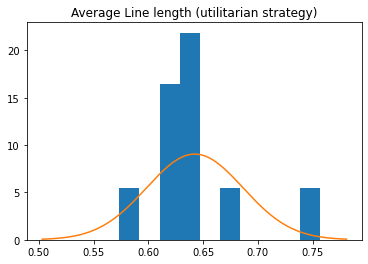

Jarque Bera (p-value, utilitarian strategy): 0.08762202512775585


'Total average waiting: 3.854392012354979'

Strategy: base


floor
0    1.100256
1    0.186107
2    0.154712
3    0.168693
4    0.225182
5    0.317554
dtype: float64

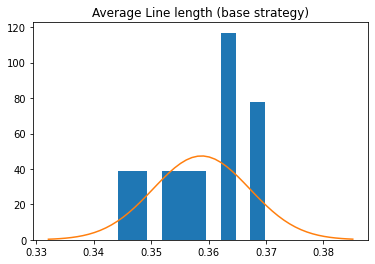

Jarque Bera (p-value, base strategy): 0.7063599460866375


'Total average waiting: 2.1525033531842293'

Strategy: top_floor_rest


floor
0    1.101627
1    0.189412
2    0.156453
3    0.165903
4    0.224055
5    0.317329
dtype: float64

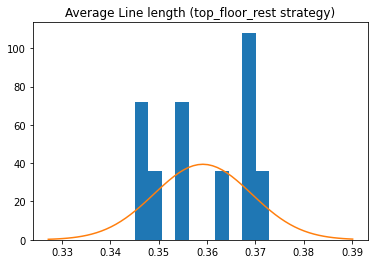

Jarque Bera (p-value, top_floor_rest strategy): 0.5680905650173844


'Total average waiting: 2.154778143583613'

Strategy: ground_floor_rest


floor
0    1.073533
1    0.183840
2    0.156622
3    0.171568
4    0.223924
5    0.328702
dtype: float64

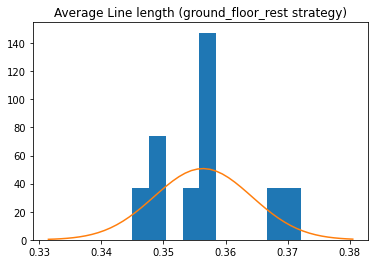

Jarque Bera (p-value, ground_floor_rest strategy): 0.7302502903568228


'Total average waiting: 2.138187779719968'

Strategy: alternative_rest


floor
0    1.105502
1    0.183298
2    0.153771
3    0.169143
4    0.229625
5    0.316468
dtype: float64

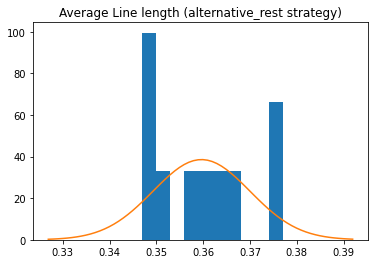

Jarque Bera (p-value, alternative_rest strategy): 0.6661547673217445


'Total average waiting: 2.157806055519367'

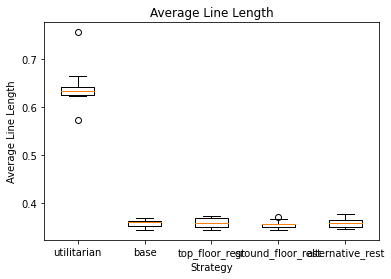

Levene:


,W,pval,equal_var
levene,2.429544,0.061369,True


ANOVA:


,Source,SS,DF,MS,F,p-unc,np2
0,level_1,0.644988,4,0.161247,317.451099,2.396093e-32,0.965774
1,Within,0.022857,45,0.000508,NaN,NaN,NaN


Pairwise t-test:


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,alternative_rest,base,0.359634,0.358751,0.000884,0.010079,0.087685,0.999986,0.037557
1,alternative_rest,ground_floor_rest,0.359634,0.356365,0.003270,0.010079,0.324405,0.997515,0.138948
2,alternative_rest,top_floor_rest,0.359634,0.359130,0.000505,0.010079,0.050069,0.999999,0.021445
3,alternative_rest,utilitarian,0.359634,0.642399,-0.282764,0.010079,-28.054483,0.000000,-12.016219
4,base,ground_floor_rest,0.358751,0.356365,0.002386,0.010079,0.236720,0.999278,0.101391
5,base,top_floor_rest,0.358751,0.359130,-0.000379,0.010079,-0.037616,1.000000,-0.016111
6,base,utilitarian,0.358751,0.642399,-0.283648,0.010079,-28.142168,0.000000,-12.053776
7,ground_floor_rest,top_floor_rest,0.356365,0.359130,-0.002765,0.010079,-0.274336,0.998710,-0.117503
8,ground_floor_rest,utilitarian,0.356365,0.642399,-0.286034,0.010079,-28.378888,0.000000,-12.155167
9,top_floor_rest,utilitarian,0.359130,0.642399,-0.283269,0.010079,-28.104553,0.000000,-12.037665


In [35]:
waiting_total = pd.DataFrame()

for strategy_name, d in DATA.items():
    print(f"Strategy: {strategy_name}")
    people_waiting_inline_per_floor = d["waiting"].groupby(["arrival"]).sum()
    people_waiting_inline_per_floor.index.set_names("floor", inplace=True)
    t = np.array(people_waiting_inline_per_floor.columns.get_level_values(1))
    t_1 = np.append(people_waiting_inline_per_floor.columns.get_level_values(1)[1:], 0)
    time_active = t_1 - t
    time_active[time_active < 0] = (np.maximum(SIMULATION_TIME - t, 0))[time_active < 0]
    time_active = np.minimum(time_active, SIMULATION_TIME)
    waiting_times_time = people_waiting_inline_per_floor * time_active
    average_people_in_line_per_floor_per_iteration = waiting_times_time.groupby(["iteration"], axis=1).sum()/SIMULATION_TIME
    average_people_in_line_per_floor = average_people_in_line_per_floor_per_iteration.mean(axis=1) # Hier moet dan ook nog een statistische test ofzo
    display(average_people_in_line_per_floor)

    average_line_per_iteration = average_people_in_line_per_floor_per_iteration.mean()
    average_line_per_iteration = average_line_per_iteration.groupby(average_line_per_iteration.index%10).mean()
    
    waiting_total.loc[:, strategy_name] = average_line_per_iteration
    plt.hist(average_line_per_iteration, density=True)
    plt.title(f"Average Line length ({strategy_name} strategy)")
    _mean, _std = sts.norm.fit(average_line_per_iteration)
    plt.plot(
        np.arange(
            average_line_per_iteration.mean() - 3*average_line_per_iteration.std(), 
            average_line_per_iteration.mean() + 3*average_line_per_iteration.std(), 
            0.001),
        sts.norm.pdf(np.arange(
            average_line_per_iteration.mean() - 3*average_line_per_iteration.std(), 
            average_line_per_iteration.mean() + 3*average_line_per_iteration.std(), 
            0.001),
            _mean,
            _std
        ))
    plt.show()
    print(f"Jarque Bera (p-value, {strategy_name} strategy): {sts.jarque_bera(average_line_per_iteration).pvalue}")
    display(f"Total average waiting: {average_people_in_line_per_floor.sum()}")

print("\n")

plt.boxplot(waiting_total, labels=waiting_total.columns)
plt.title("Average Line Length")
plt.xlabel("Strategy")
plt.ylabel("Average Line Length")
plt.show()

test_df = waiting_total.stack().reset_index()
print("Levene:")
hom_test = pg.homoscedasticity(test_df, dv=0, group="level_1")
display(hom_test)

if hom_test["equal_var"].iloc[0]:
    print("ANOVA:")
    display(pg.anova(test_df, dv=0, between="level_1", detailed=True))
else:
    print("Welch ANOVA:")
    display(pg.welch_anova(test_df, dv=0, between="level_1"))

# print("Kruskal Willis:")
# display(pg.kruskal(test_df, dv=0, between="level_1"))

print("Pairwise t-test:")
display(pg.pairwise_tukey(test_df, dv=0, between="level_1"))

## Average elevator occupancy

Strategy: utilitarian


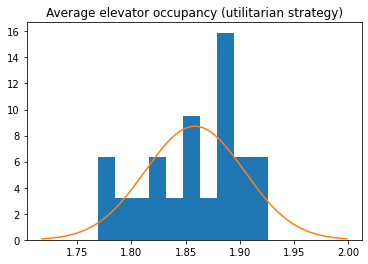

Jaque Bera (p-value, utilitarian strategy): 0.5097411196278896


'Average elevator occupancy: 1.8585198214201497'

Strategy: base


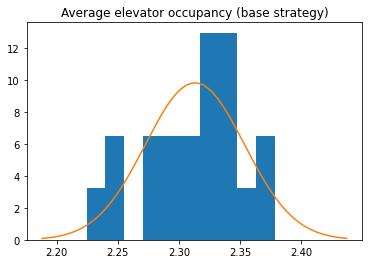

Jaque Bera (p-value, base strategy): 0.6217823162154004


'Average elevator occupancy: 2.313134196235101'

Strategy: top_floor_rest


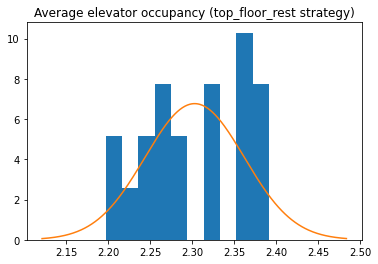

Jaque Bera (p-value, top_floor_rest strategy): 0.494078316049416


'Average elevator occupancy: 2.3030400144955308'

Strategy: ground_floor_rest


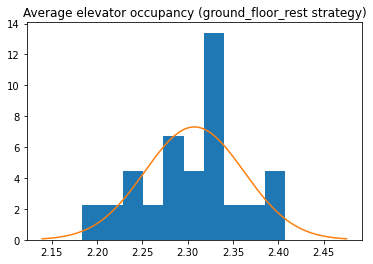

Jaque Bera (p-value, ground_floor_rest strategy): 0.8625703139934664


'Average elevator occupancy: 2.307330120736546'

Strategy: alternative_rest


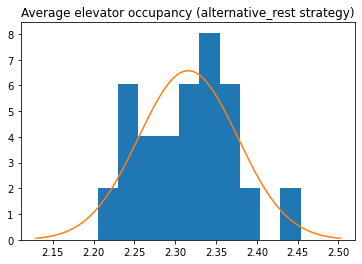

Jaque Bera (p-value, alternative_rest strategy): 0.9177751507830203


'Average elevator occupancy: 2.3158956046461547'

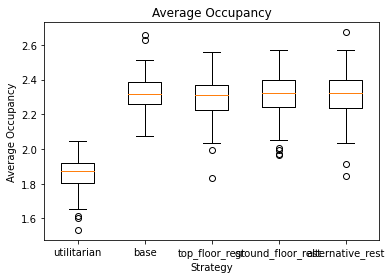

Levene:


,W,pval,equal_var
levene,1.093869,0.358852,True


ANOVA:


,Source,SS,DF,MS,F,p-unc,np2
0,level_1,16.305919,4,4.076480,288.515525,7.757008e-128,0.699829
1,Within,6.993930,495,0.014129,NaN,NaN,NaN


Pairwise t-test:


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,alternative_rest,base,2.315896,2.313134,0.002761,0.01681,0.164270,9.998364e-01,0.023143
1,alternative_rest,ground_floor_rest,2.315896,2.307330,0.008565,0.01681,0.509541,9.864128e-01,0.071787
2,alternative_rest,top_floor_rest,2.315896,2.303040,0.012856,0.01681,0.764749,9.405464e-01,0.107742
3,alternative_rest,utilitarian,2.315896,1.858520,0.457376,0.01681,27.208219,8.992806e-15,3.833230
4,base,ground_floor_rest,2.313134,2.307330,0.005804,0.01681,0.345271,9.969428e-01,0.048643
5,base,top_floor_rest,2.313134,2.303040,0.010094,0.01681,0.600479,9.749810e-01,0.084599
6,base,utilitarian,2.313134,1.858520,0.454614,0.01681,27.043949,8.992806e-15,3.810087
7,ground_floor_rest,top_floor_rest,2.307330,2.303040,0.004290,0.01681,0.255208,9.990641e-01,0.035955
8,ground_floor_rest,utilitarian,2.307330,1.858520,0.448810,0.01681,26.698678,8.992806e-15,3.761443
9,top_floor_rest,utilitarian,2.303040,1.858520,0.444520,0.01681,26.443470,8.992806e-15,3.725488


In [36]:
occupancy_total = pd.DataFrame()

for strategy_name, d in DATA.items():
    print(f"Strategy: {strategy_name}")
    people_in_elevator = d["elevator"].sum().to_frame().transpose()
    t = np.array(people_in_elevator.columns.get_level_values(1))
    t_1 = np.append(people_in_elevator.columns.get_level_values(1)[1:], 0)
    time_active = t_1 - t
    time_active[time_active < 0] = (np.maximum(SIMULATION_TIME - t, 0))[time_active < 0]
    time_active = np.minimum(time_active, SIMULATION_TIME)
    elevator_times_time = people_in_elevator * time_active
    average_people_in_elevator_per_iteration = elevator_times_time.groupby(["iteration"], axis=1).sum()/SIMULATION_TIME
    average_people_in_line_per_floor = float(average_people_in_elevator_per_iteration.mean(axis=1)) # Hier moet dan ook nog een statistische test ofzo

    occupancy_total.loc[:, strategy_name] = average_people_in_elevator_per_iteration.transpose()[0]
    average_people_in_elevator_per_iteration = average_people_in_elevator_per_iteration.groupby(average_people_in_elevator_per_iteration.columns%20, axis=1).mean()
    plt.hist(average_people_in_elevator_per_iteration.iloc[0], density=True)
    plt.title(f"Average elevator occupancy ({strategy_name} strategy)")
    _mean, _std = sts.norm.fit(average_people_in_elevator_per_iteration.iloc[0])
    plt.plot(
        np.arange(
            average_people_in_elevator_per_iteration.iloc[0].mean() - 3 * average_people_in_elevator_per_iteration.iloc[0].std(), 
            average_people_in_elevator_per_iteration.iloc[0].mean() + 3 * average_people_in_elevator_per_iteration.iloc[0].std(), 
            0.001),
        sts.norm.pdf(np.arange(
            average_people_in_elevator_per_iteration.iloc[0].mean() - 3 * average_people_in_elevator_per_iteration.iloc[0].std(), 
            average_people_in_elevator_per_iteration.iloc[0].mean() + 3 * average_people_in_elevator_per_iteration.iloc[0].std(),
            0.001),
            _mean,
            _std
        ))
    plt.show()
    print(f"Jaque Bera (p-value, {strategy_name} strategy): {sts.jarque_bera(average_people_in_elevator_per_iteration.iloc[0]).pvalue}")

    display(f"Average elevator occupancy: {average_people_in_line_per_floor}")


plt.boxplot(occupancy_total, labels=occupancy_total.columns)
plt.title("Average Occupancy")
plt.xlabel("Strategy")
plt.ylabel("Average Occupancy")
plt.show()

_test_df = occupancy_total.stack().reset_index()

print("Levene:")
hom_test = pg.homoscedasticity(_test_df, dv=0, group="level_1")
display(hom_test)

if hom_test["equal_var"].iloc[0]:
    print("ANOVA:")
    display(pg.anova(_test_df, dv=0, between="level_1", detailed=True))
else:
    print("Welch ANOVA:")
    display(pg.welch_anova(_test_df, dv=0, between="level_1"))

print("Pairwise t-test:")
display(pg.pairwise_tukey(_test_df, dv=0, between="level_1"))

## Average waiting time (line)
M'n idee om dit te berekenen gaat als volgt:
1. Omdat de gemiddelde tijd dat je ergens moet wachten niet afhankelijk is van hoe laat je er komt, maar hoe lang hij is in de situatie.
2. Dus als ik een manier kan bedenken om te meten hoe lang hij in elke situatie zit, dan kan je daar het gemiddelde van nemen (afhankelijk van hoe lang hij in elke situatie zit).
3. Dit kan je doen voor de wachtenden en de lift, dan kan je daarna dat bij elkaar optellen om de gemiddelde wachttijd te berekenen.

Strategy: utilitarian


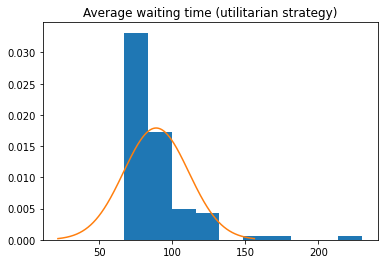

Jaque Bera (p-value, utilitarian strategy): 0.0


'Average waiting time (s): 89.08671979083863'

Strategy: base


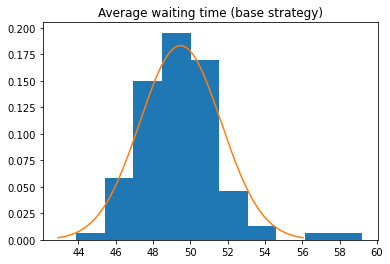

Jaque Bera (p-value, base strategy): 0.0


'Average waiting time (s): 49.475472687592685'

Strategy: top_floor_rest


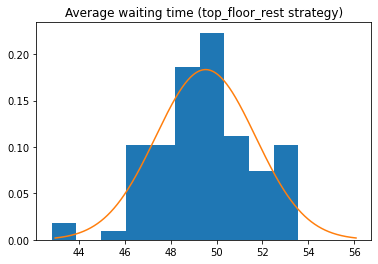

Jaque Bera (p-value, top_floor_rest strategy): 0.5804813172878068


'Average waiting time (s): 49.52351705714548'

Strategy: ground_floor_rest


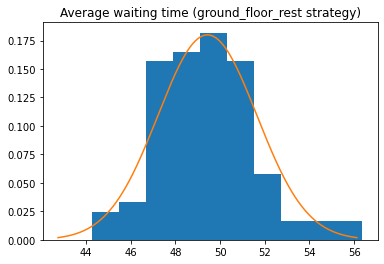

Jaque Bera (p-value, ground_floor_rest strategy): 0.05430863607229508


'Average waiting time (s): 49.43475623317006'

Strategy: alternative_rest


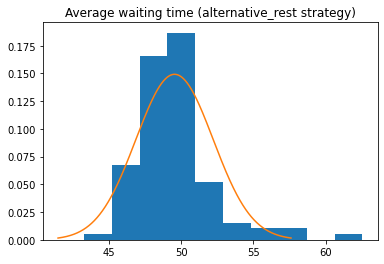

Jaque Bera (p-value, alternative_rest strategy): 0.0


'Average waiting time (s): 49.54719925520714'

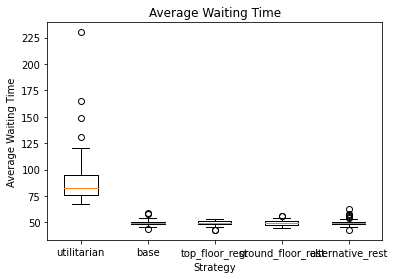

Levene:


,W,pval,equal_var
levene,37.732848,1.456359e-27,False


Welch ANOVA:


,Source,ddof1,ddof2,F,p-unc,np2
0,level_1,4,243.334513,77.321183,3.153904e-42,0.707596


Pairwise t-test:


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,alternative_rest,base,49.547199,49.475473,0.071727,1.446969,0.049570,9.999986e-01,0.006984
1,alternative_rest,ground_floor_rest,49.547199,49.434756,0.112443,1.446969,0.077709,9.999917e-01,0.010948
2,alternative_rest,top_floor_rest,49.547199,49.523517,0.023682,1.446969,0.016367,1.000000e+00,0.002306
3,alternative_rest,utilitarian,49.547199,89.086720,-39.539521,1.446969,-27.325764,8.992806e-15,-3.849790
4,base,ground_floor_rest,49.475473,49.434756,0.040716,1.446969,0.028139,9.999999e-01,0.003964
5,base,top_floor_rest,49.475473,49.523517,-0.048044,1.446969,-0.033203,9.999997e-01,-0.004678
6,base,utilitarian,49.475473,89.086720,-39.611247,1.446969,-27.375334,8.992806e-15,-3.856774
7,ground_floor_rest,top_floor_rest,49.434756,49.523517,-0.088761,1.446969,-0.061343,9.999968e-01,-0.008642
8,ground_floor_rest,utilitarian,49.434756,89.086720,-39.651964,1.446969,-27.403473,8.992806e-15,-3.860738
9,top_floor_rest,utilitarian,49.523517,89.086720,-39.563203,1.446969,-27.342131,8.992806e-15,-3.852096


In [41]:
waiting_time_total = pd.DataFrame()


for strategy_name, d in DATA.items():
    print(f"Strategy: {strategy_name}")
    total_people_waiting_at_time = d["waiting"].sum()
    waiting_in_line_change = total_people_waiting_at_time.diff()
    waiting_in_line_change.loc[:, STARTING_TIME] = 0 # beginning has no change
    only_waiting_in_line_change = waiting_in_line_change[waiting_in_line_change != 0].dropna()

    positive_change = only_waiting_in_line_change[only_waiting_in_line_change > 0]
    negative_change = only_waiting_in_line_change[only_waiting_in_line_change < 0]

    for c in positive_change.unique():
        to_concat = [positive_change]
        for _ in range(int(c) - 1):
            to_concat.append(positive_change[positive_change == c])
        positive_change = pd.concat(to_concat)

    positive_change.sort_index(inplace=True)

    for c in negative_change.unique():
        to_concat = [negative_change]
        for _ in range(int(-1*c) - 1):
            to_concat.append(negative_change[negative_change == c])
        negative_change = pd.concat(to_concat)

    positive_change.sort_index(inplace=True)
    positive_change = positive_change.to_frame()
    positive_change = positive_change.set_index(positive_change.groupby(level=0).cumcount(), append=True)
    positive_change = positive_change.reset_index(level = 1)
    negative_change.sort_index(inplace=True)
    negative_change = negative_change.to_frame()
    negative_change = negative_change.set_index(negative_change.groupby(level=0).cumcount(), append=True)
    negative_change = negative_change.reset_index(level = 1)

    change_times = positive_change["time"].to_frame().join(negative_change["time"], lsuffix="-p", rsuffix="-n")
    waiting_per_iteration = (change_times["time-n"] - change_times["time-p"]).groupby(level=0).mean()
        

#     waiting_per_iteration = waiting_per_iteration.groupby(waiting_per_iteration.index%10).mean()
    waiting_time_total.loc[:, strategy_name] = waiting_per_iteration
    plt.hist(waiting_per_iteration, density=True)
    plt.title(f"Average waiting time ({strategy_name} strategy)")
    _mean, _std = sts.norm.fit(waiting_per_iteration)
    plt.plot(
        np.arange(
            waiting_per_iteration.mean() - 3 * waiting_per_iteration.std(), 
            waiting_per_iteration.mean() + 3 * waiting_per_iteration.std(),
            0.001),
        sts.norm.pdf(np.arange(
            waiting_per_iteration.mean() - 3 * waiting_per_iteration.std(), 
            waiting_per_iteration.mean() + 3 * waiting_per_iteration.std(),
            0.001),
            _mean,
            _std
        ))
    plt.show()
    print(f"Jaque Bera (p-value, {strategy_name} strategy): {sts.jarque_bera(waiting_per_iteration).pvalue}")

    average_waiting = waiting_per_iteration.mean()
    display(f"Average waiting time (s): {average_waiting}")

plt.boxplot(waiting_time_total, labels=waiting_time_total.columns)
plt.title("Average Waiting Time")
plt.xlabel("Strategy")
plt.ylabel("Average Waiting Time")
plt.show()

___test_df = waiting_time_total.stack().reset_index()

print("Levene:")
hom_test = pg.homoscedasticity(___test_df, dv=0, group="level_1")
display(hom_test)

if hom_test["equal_var"].iloc[0]:
    print("ANOVA:")
    display(pg.anova(___test_df, dv=0, between="level_1", detailed=True))
else:
    print("Welch ANOVA:")
    display(pg.welch_anova(___test_df, dv=0, between="level_1"))

print("Pairwise t-test:")
display(pg.pairwise_tukey(___test_df, dv=0, between="level_1"))

Strategy: utilitarian


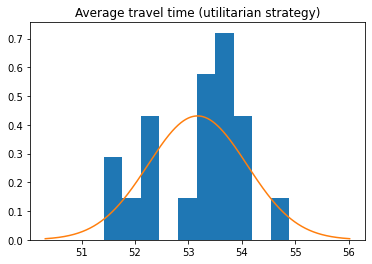

Jaque Bera (p-value, utilitarian strategy): 0.6026790390051873


'Average travel time (s): 53.169214548345415'

Strategy: base


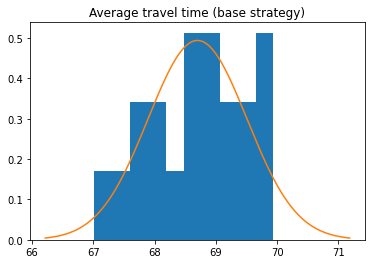

Jaque Bera (p-value, base strategy): 0.6520402508359407


'Average travel time (s): 68.70121038960227'

Strategy: top_floor_rest


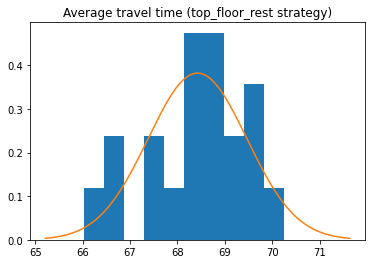

Jaque Bera (p-value, top_floor_rest strategy): 0.5456849500722547


'Average travel time (s): 68.42464492038931'

Strategy: ground_floor_rest


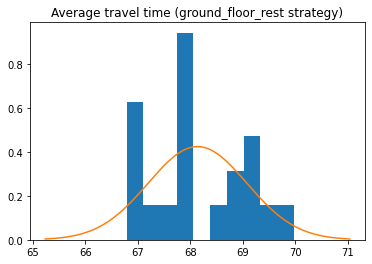

Jaque Bera (p-value, ground_floor_rest strategy): 0.6040191455789391


'Average travel time (s): 68.1390499055441'

Strategy: alternative_rest


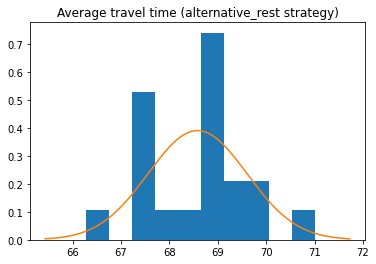

Jaque Bera (p-value, alternative_rest strategy): 0.9465919374959


'Average travel time (s): 68.58038389600054'

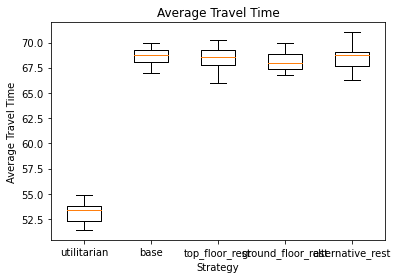

Levene:


,W,pval,equal_var
levene,0.149483,0.962808,True


ANOVA:


,Source,SS,DF,MS,F,p-unc,np2
0,level_1,3745.115475,4,936.278869,981.928439,2.528084e-76,0.976384
1,Within,90.583477,95,0.953510,NaN,NaN,NaN


Pairwise t-test:


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,alternative_rest,base,68.580384,68.701210,-0.120826,0.30879,-0.391291,9.949637e-01,-0.121279
1,alternative_rest,ground_floor_rest,68.580384,68.139050,0.441334,0.30879,1.429238,6.105067e-01,0.442985
2,alternative_rest,top_floor_rest,68.580384,68.424645,0.155739,0.30879,0.504353,9.867552e-01,0.156322
3,alternative_rest,utilitarian,68.580384,53.169215,15.411169,0.30879,49.908314,8.770762e-15,15.468837
4,base,ground_floor_rest,68.701210,68.139050,0.562160,0.30879,1.820529,3.679828e-01,0.564264
5,base,top_floor_rest,68.701210,68.424645,0.276565,0.30879,0.895644,8.978513e-01,0.277600
6,base,utilitarian,68.701210,53.169215,15.531996,0.30879,50.299605,8.770762e-15,15.590116
7,ground_floor_rest,top_floor_rest,68.139050,68.424645,-0.285595,0.30879,-0.924885,8.866033e-01,-0.286664
8,ground_floor_rest,utilitarian,68.139050,53.169215,14.969835,0.30879,48.479076,8.770762e-15,15.025852
9,top_floor_rest,utilitarian,68.424645,53.169215,15.255430,0.30879,49.403961,8.770762e-15,15.312515


In [40]:
travel_time_total = pd.DataFrame()


for strategy_name, d in DATA.items():
    print(f"Strategy: {strategy_name}")
    total_people_waiting_at_time = d["elevator"].sum()
    waiting_in_line_change = total_people_waiting_at_time.diff()
    waiting_in_line_change.loc[:, STARTING_TIME] = 0 # beginning has no change
    only_waiting_in_line_change = waiting_in_line_change[waiting_in_line_change != 0].dropna()

    positive_change = only_waiting_in_line_change[only_waiting_in_line_change > 0]
    negative_change = only_waiting_in_line_change[only_waiting_in_line_change < 0]

    for c in positive_change.unique():
        to_concat = [positive_change]
        for _ in range(int(c) - 1):
            to_concat.append(positive_change[positive_change == c])
        positive_change = pd.concat(to_concat)

    positive_change.sort_index(inplace=True)

    for c in negative_change.unique():
        to_concat = [negative_change]
        for _ in range(int(-1*c) - 1):
            to_concat.append(negative_change[negative_change == c])
        negative_change = pd.concat(to_concat)

    positive_change.sort_index(inplace=True)
    positive_change = positive_change.to_frame()
    positive_change = positive_change.set_index(positive_change.groupby(level=0).cumcount(), append=True)
    positive_change = positive_change.reset_index(level = 1)
    negative_change.sort_index(inplace=True)
    negative_change = negative_change.to_frame()
    negative_change = negative_change.set_index(negative_change.groupby(level=0).cumcount(), append=True)
    negative_change = negative_change.reset_index(level = 1)

    change_times = positive_change["time"].to_frame().join(negative_change["time"], lsuffix="-p", rsuffix="-n")
    waiting_per_iteration = (change_times["time-n"] - change_times["time-p"]).groupby(level=0).mean()
        
#     waiting_per_iteration = waiting_per_iteration.groupby(waiting_per_iteration.index%20).mean()
    travel_time_total.loc[:, strategy_name] = waiting_per_iteration
    plt.hist(waiting_per_iteration, density=True)
    plt.title(f"Average travel time ({strategy_name} strategy)")
    _mean, _std = sts.norm.fit(waiting_per_iteration)
    plt.plot(
        np.arange(
            waiting_per_iteration.mean() - 3 * waiting_per_iteration.std(), 
            waiting_per_iteration.mean() + 3 * waiting_per_iteration.std(),
            0.001),
        sts.norm.pdf(np.arange(
            waiting_per_iteration.mean() - 3 * waiting_per_iteration.std(), 
            waiting_per_iteration.mean() + 3 * waiting_per_iteration.std(),
            0.001),
            _mean,
            _std
        ))
    plt.show()
    print(f"Jaque Bera (p-value, {strategy_name} strategy): {sts.jarque_bera(waiting_per_iteration).pvalue}")

    average_waiting = waiting_per_iteration.mean()
    display(f"Average travel time (s): {average_waiting}")

plt.boxplot(travel_time_total, labels=travel_time_total.columns)
plt.title("Average Travel Time")
plt.xlabel("Strategy")
plt.ylabel("Average Travel Time")
plt.show()

___test_df = travel_time_total.stack().reset_index()

print("Levene:")
hom_test = pg.homoscedasticity(___test_df, dv=0, group="level_1")
display(hom_test)

if hom_test["equal_var"].iloc[0]:
    print("ANOVA:")
    display(pg.anova(___test_df, dv=0, between="level_1", detailed=True))
else:
    print("Welch ANOVA:")
    display(pg.welch_anova(___test_df, dv=0, between="level_1"))

print("Pairwise t-test:")
display(pg.pairwise_tukey(___test_df, dv=0, between="level_1"))

## System time

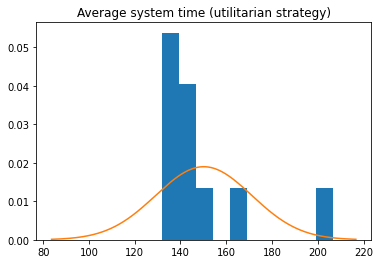

Jaque Bera (p-value, utilitarian strategy): 0.020954847505741503


'Average waiting time (s): 150.1493447516759'

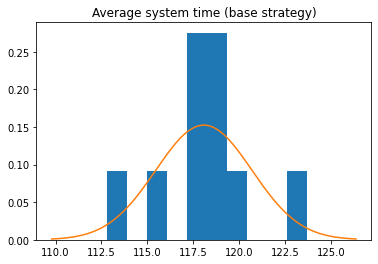

Jaque Bera (p-value, base strategy): 0.8487794187734314


'Average waiting time (s): 118.06658595094629'

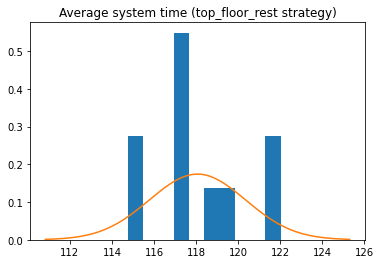

Jaque Bera (p-value, top_floor_rest strategy): 0.8113241579104276


'Average waiting time (s): 118.07170461617716'

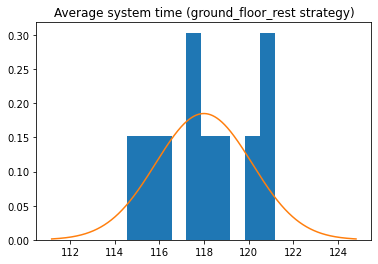

Jaque Bera (p-value, ground_floor_rest strategy): 0.7364218763429151


'Average waiting time (s): 117.99370217391488'

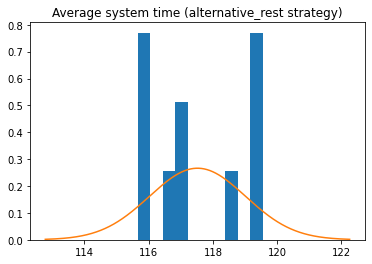

Jaque Bera (p-value, alternative_rest strategy): 0.5474364204656399


'Average waiting time (s): 117.5204698893779'

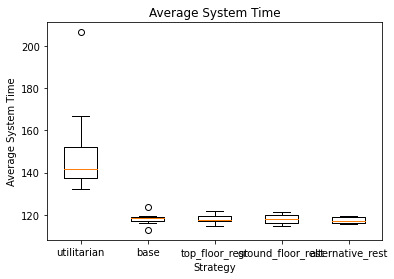

Levene:


,W,pval,equal_var
levene,3.154622,0.022778,False


Welch ANOVA:


,Source,ddof1,ddof2,F,p-unc,np2
0,level_1,4,21.799877,5.004478,0.005128,0.643335


Pairwise t-test:


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,alternative_rest,base,117.520470,118.066586,-0.546116,4.526522,-0.120648,9.999502e-01,-0.051676
1,alternative_rest,ground_floor_rest,117.520470,117.993702,-0.473232,4.526522,-0.104547,9.999719e-01,-0.044779
2,alternative_rest,top_floor_rest,117.520470,118.071705,-0.551235,4.526522,-0.121779,9.999483e-01,-0.052160
3,alternative_rest,utilitarian,117.520470,150.149345,-32.628875,4.526522,-7.208377,4.928183e-08,-3.087472
4,base,ground_floor_rest,118.066586,117.993702,0.072884,4.526522,0.016101,1.000000e+00,0.006897
5,base,top_floor_rest,118.066586,118.071705,-0.005119,4.526522,-0.001131,1.000000e+00,-0.000484
6,base,utilitarian,118.066586,150.149345,-32.082759,4.526522,-7.087729,7.427635e-08,-3.035797
7,ground_floor_rest,top_floor_rest,117.993702,118.071705,-0.078002,4.526522,-0.017232,1.000000e+00,-0.007381
8,ground_floor_rest,utilitarian,117.993702,150.149345,-32.155643,4.526522,-7.103831,7.031666e-08,-3.042693
9,top_floor_rest,utilitarian,118.071705,150.149345,-32.077640,4.526522,-7.086598,7.456271e-08,-3.035312


In [44]:
system_time = travel_time_total + waiting_time_total

system_time = system_time.groupby(system_time.index %10).mean()
for strategy_name in system_time.columns:
    plt.hist(system_time[strategy_name], density=True)
    plt.title(f"Average system time ({strategy_name} strategy)")
    _mean, _std = sts.norm.fit(system_time[strategy_name])
    plt.plot(
        np.arange(
            system_time[strategy_name].mean() - 3 * system_time[strategy_name].std(), 
            system_time[strategy_name].mean() + 3 * system_time[strategy_name].std(),
            0.001),
        sts.norm.pdf(np.arange(
            system_time[strategy_name].mean() - 3 * system_time[strategy_name].std(), 
            system_time[strategy_name].mean() + 3 * system_time[strategy_name].std(),
            0.001),
            _mean,
            _std
        ))
    plt.show()
    print(f"Jaque Bera (p-value, {strategy_name} strategy): {sts.jarque_bera(system_time[strategy_name]).pvalue}")

    average_waiting = system_time[strategy_name].mean()
    display(f"Average waiting time (s): {average_waiting}")

plt.boxplot(system_time, labels=system_time.columns)
plt.title("Average System Time")
plt.xlabel("Strategy")
plt.ylabel("Average System Time")
plt.show()

___test_df = system_time.stack().reset_index()

print("Levene:")
hom_test = pg.homoscedasticity(___test_df, dv=0, group="level_1")
display(hom_test)

if hom_test["equal_var"].iloc[0]:
    print("ANOVA:")
    display(pg.anova(___test_df, dv=0, between="level_1", detailed=True))
else:
    print("Welch ANOVA:")
    display(pg.welch_anova(___test_df, dv=0, between="level_1"))

print("Pairwise t-test:")
display(pg.pairwise_tukey(___test_df, dv=0, between="level_1"))